In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd
from numpy import load

import matplotlib.pyplot as plt
from matplotlib import cm 
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
import keras

import time, cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB3

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

import itertools

from sklearn import metrics

import seaborn as sns

In [ ]:
#chargement de X_brain et y_brain
np.load.__defaults__=(None, True, True, 'ASCII')

X_brain= load('/content/drive/My Drive/Colab_outputs/X_brain_150.npy')
y_brain = load('/content/drive/My Drive/Colab_outputs/y_brain.npy')

indices = list(range(0,len(y_brain)))

# Shape de X_brain et y_brain
print('Shape of X:', X_brain.shape)
print('Shape of y:',y_brain.shape)

Shape of X: (2501, 150, 150, 3)
Shape of y: (2501,)


In [ ]:
### split des données ###

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_brain, y_brain, indices, test_size=0.2, random_state=123)

np.save('/content/drive/My Drive/Colab_outputs/X_train_lenet.npy', X_train)
np.save('/content/drive/My Drive/Colab_outputs/X_test_lenet.npy', X_test)
np.save('/content/drive/My Drive/Colab_outputs/y_train_lenet.npy', y_train)
np.save('/content/drive/My Drive/Colab_outputs/y_test_lenet.npy', y_test)
np.save('/content/drive/My Drive/Colab_outputs/indices_test_lenet.npy', indices_test)
np.save('/content/drive/My Drive/Colab_outputs/indices_train_lenet.npy', indices_train)

# Shape de X_train et y_train
print('Shape of X:', X_train.shape)
print('Shape of y:',y_train.shape)

Shape of X: (2000, 150, 150, 3)
Shape of y: (2000,)


In [ ]:
# valeurs comprises entre 0 et 1 et transformation en vecteurs catégoriels binaires

X_train = X_train/255
X_test = X_test/255

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa
fl = tfa.losses.SigmoidFocalCrossEntropy()

In [ ]:
def focal_loss_custom(alpha, gamma):
   def binary_focal_loss(y_true, y_pred):
      fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = K.ones_like(y_true)
      focal_loss = fl(y_true, y_pred)
      return focal_loss
   return binary_focal_loss

In [ ]:
## Réseau de Neurones Convolutif LeNet5

inputs = Input(shape = X_train[0,...].shape)
layer1 = Conv2D(filters = 30, kernel_size = (5, 5), padding = 'valid', activation = 'relu')
layer2 = MaxPooling2D(pool_size=(2,2))
layer3 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'valid', activation = 'relu')
layer4 = MaxPooling2D(pool_size=(2,2))
layer5 = Dropout(rate = 0.2)
layer6 = Flatten()
layer7 = Dense(units=128, activation = 'relu')
output_layer = Dense(units=1, activation = 'sigmoid')

x = layer1(inputs)
x = layer2(x)
x = layer3(x)
x = layer4(x)
x = layer5(x)
x = layer6(x)
x = layer7(x)
outputs = output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

model.compile(loss = focal_loss_custom(alpha=0.7, gamma=2.0),
              optimizer = "adam",
              metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 146, 146, 30)      2280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 16)        4336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 35, 35, 16)        0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K

EPOCHS = 16

# EarlyStopping qui suit la valeur val_loss, arrête l'entraînement s'il n'y a pas de changement vers val_loss après 3 époques et conserve les meilleurs poids une fois que l'entraînement s'arrête
early_stopping = EarlyStopping(monitor = 'val_loss',
                    min_delta = 0.001,
                    mode = 'min',
                    patience = 5,
                    verbose = 1,
                    restore_best_weights = True)

#ReduceLROnPlateau qui suit la métrique val_loss, divise le coefficient d'apprentissage par 2 si au bout de 3 epochs, val_loss n'a pas varié de 0.01. 
#On attribue une pause de 2 epochs entre 2 cycles
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                        min_delta = 0.01,
                        patience = 5,
                        factor = 0.5, 
                        cooldown = 2,
                        verbose = 1)

# save the best model
checkpoint_filepath = 'Documents/projet-hemorragie/data-source/outputs/tmp/best-cnn-focal'

model_checkpoint = ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_accuracy',
                        mode='max',
                        save_best_only=True)

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
class_weights = {i:w for i,w in enumerate(class_weights)}

training_history_lenet = model.fit(X_train, 
                                     y_train, epochs = EPOCHS, 
                                     batch_size = 200, 
                                     validation_split = 0.2, 
                                     #callbacks=[reduce_learning_rate, early_stopping], 
                                     class_weight=class_weights)

# The model weights (that are considered the best) are loaded into the model
#model.load_weights(checkpoint_filepath)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/16
8/8 [==============================] - 94s 11s/step - loss: 0.2747 - accuracy: 0.4588 - val_loss: 0.1574 - val_accuracy: 0.1325
Epoch 2/16
8/8 [==============================] - 76s 10s/step - loss: 0.0757 - accuracy: 0.2144 - val_loss: 0.0598 - val_accuracy: 0.5650
Epoch 3/16
8/8 [==============================] - 83s 10s/step - loss: 0.0636 - accuracy: 0.6381 - val_loss: 0.0631 - val_accuracy: 0.5975
Epoch 4/16
8/8 [==============================] - 81s 10s/step - loss: 0.0509 - accuracy: 0.6594 - val_loss: 0.0724 - val_accuracy: 0.5525
Epoch 5/16
8/8 [==============================] - 80s 10s/step - loss: 0.0422 - accuracy: 0.7231 - val_loss: 0.0399 - val_accuracy: 0.7775
Epoch 6/16
8/8 [==============================] - 76s 9s/step - loss: 0.0330 - accuracy: 0.7831 - val_loss: 0.0385 - val_accuracy: 0.8200
Epoch 7/16
8/8 [==============================] - 76s 9s/step - loss: 0.0249 - accuracy: 0.8444 - val_loss: 0.0428 - val_accuracy: 0.7825
Epoch 8/16
8/8 [=============

In [ ]:
#model.save('/content/drive/My Drive/Colab_outputs/Lenet-FL-3.h5')
model.save('/content/drive/My Drive/Colab_outputs/Lenet-FL-Last.h5', include_optimizer=False)

In [ ]:
train_acc = training_history_lenet.history['accuracy']
val_acc = training_history_lenet.history['val_accuracy']
train_loss = training_history_lenet.history['loss']
val_loss = training_history_lenet.history['val_loss']

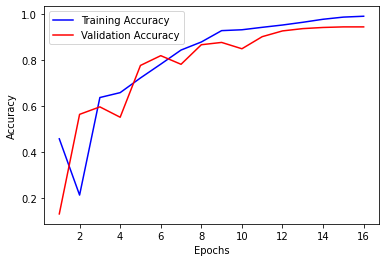

In [ ]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , len(train_acc)+1, 1),
         train_acc,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , len(val_acc)+1, 1),
         val_acc, 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [ ]:
#prediction 
test_pred = model.predict(X_test)

test_pred_class = []

for i in test_pred[:,0]:
    if i > 0.5:
        test_pred_class.append(1)
    else:
        test_pred_class.append(0)

16/16 [==============================] - 8s 476ms/step


In [ ]:
test_pred_array = np.array(test_pred_class)
pd.crosstab(y_test, test_pred_array, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,415,26
1,7,53


In [ ]:
#classification
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

print(classification_report_imbalanced(y_test, test_pred_class))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.94      0.88      0.96      0.91      0.84       441
          1       0.67      0.88      0.94      0.76      0.91      0.83        60

avg / total       0.95      0.93      0.89      0.94      0.91      0.83       501



In [ ]:
model = keras.models.load_model('/content/drive/My Drive/Colab_outputs/Lenet-FL-4.h5')

In [ ]:
test_pred = model.predict(X_test)

test_pred_class = []

for i in test_pred[:,0]:
    if i > 0.5:
        test_pred_class.append(1)
    else:
        test_pred_class.append(0)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 [==============================] - 5s 340ms/step


In [ ]:
print(test_pred[:,0])

[2.83406442e-03 2.33883616e-02 6.29168749e-02 6.34760112e-02
 1.55986071e-01 6.93855956e-02 4.30036707e-05 4.34048660e-02
 3.75805199e-02 6.25951737e-02 1.55161670e-03 2.35395223e-01
 9.08402026e-01 6.16770284e-03 3.86107014e-03 2.06334412e-01
 4.46080804e-01 1.20266914e-01 1.07802055e-03 3.48719768e-05
 1.05768726e-04 3.04248044e-03 7.99301080e-03 7.73990393e-01
 4.19972866e-06 1.20182067e-01 8.51851031e-02 1.13001829e-02
 2.15845270e-04 1.01974851e-03 9.54454064e-01 2.49429839e-04
 7.81673566e-03 7.77971931e-03 1.48966163e-01 9.08207744e-02
 8.39696050e-01 9.51999664e-01 3.71630231e-05 1.11154011e-04
 5.05916658e-04 3.24226141e-01 1.93537140e-04 2.49630123e-01
 3.94003605e-03 4.81303483e-02 1.42386898e-01 8.88640046e-01
 8.65545869e-03 4.45731159e-04 3.82028371e-02 1.88264214e-02
 1.63874686e-01 8.24367046e-01 9.71806294e-05 3.67090618e-03
 6.70522511e-01 4.47671860e-01 7.84586358e-04 2.56780893e-01
 5.47376610e-02 3.47511820e-03 4.95777131e-05 4.06155537e-04
 7.04312563e-01 4.077980

In [ ]:
test_pred_array = np.array(test_pred_class)
pd.crosstab(y_test, test_pred_array, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,400,41
1,5,55


In [ ]:
#classification
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

print(classification_report_imbalanced(y_test, test_pred_class))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.91      0.92      0.95      0.91      0.83       441
          1       0.57      0.92      0.91      0.71      0.91      0.83        60

avg / total       0.94      0.91      0.92      0.92      0.91      0.83       501

